In [2]:
import os 
os.chdir("..")


In [3]:
%load_ext autoreload
%autoreload 2
from numerics.integration.steps import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numerics.utilities.misc import *
import time
from scipy.special import erf
import pickle

In [4]:

mode = "damping"
pars = give_def_params_discrimination(flip=0, mode = mode)
params, exp_path = check_params_discrimination(pars)
[gamma1, omega1, n1, eta1, kappa1], [gamma0, omega0, n0, eta0, kappa0] = params

dtt = 1e-6
total_time = 4.
total_time, dt = get_total_time_dt(params, dt=dtt, total_time=total_time)
times = np.arange(0, total_time+ dt, dt)



Ntraj = 3000
boundsB= np.arange(-4,4.1,.1)


stop = {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}


indis = np.logspace(2,np.log10(len(times)-1), 100)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]

er=[]
deter = {}
deter["h0/h1"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}

l0,l1 = np.zeros((2,len(times)+1))

indis = np.logspace(2,np.log10(len(times)-1), 100)
indis = [int(k) for k in indis]
timind = [times[ind] for ind in indis]

deter_data_h0_h1 = np.zeros((Ntraj, len(boundsB), len(indis)))#{indb:{ind:[] for ind in indis} for indb in range(len(boundsB))}#["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}
deter_data_h1_h0 = np.zeros((Ntraj, len(boundsB), len(indis)))##{indb:{ind:[] for ind in indis} for indb in range(len(boundsB))}#["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}


n=1
ers = []
for itraj in tqdm(range(1,Ntraj)):
    try:

        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj, mode=mode, dtt=dtt, total_time_in=total_time)

        for indb,b in enumerate(boundsB):
            if b>=0:
                stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b, times))
                stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b,times))

            for ind, time_index in enumerate(indis):
                deter_1 = log_lik_ratio[time_index] < b
                deter_0 = log_lik_ratio_swap[time_index] > b
                
                deter_data_h0_h1[itraj][indb][ind] = deter_1
                deter_data_h1_h0[itraj][indb][ind] = deter_0
                
                deter["h0/h1"][indb][ind] +=  (int(deter_1) - deter["h0/h1"][indb][ind] )/n
                deter["h1/h0"][indb][ind] += (int(deter_0) - deter["h1/h0"][indb][ind])/n
        l1= l1 + log_lik_ratio
        l0 = l0 +log_lik_ratio_swap
        n+=1
    except Exception:
        ers.append(itraj)
l0/=(Ntraj - len(ers))
l1/=(Ntraj - len(ers))

100%|██████████| 2999/2999 [1:50:54<00:00,  2.22s/it]


In [5]:
bpos = boundsB[boundsB >=0]
bneg = boundsB[boundsB <0]

stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())
for k,val in enumerate(values1):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))
        
for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


cons1, cons0 = [], []
anals1, anals0 = [], []
timbin0, timbin1 = [], []
for indb, b in enumerate(boundsB[int(len(boundsB)/2):]):
    counts1, bins1 = np.histogram(stops1[indb], 50, normed=True)
    counts0, bins0 = np.histogram(stops0[indb], 50, normed=True)
    
    timms1 = np.linspace(0,np.max(bins1), 100)
    timms0 = np.linspace(0,np.max(bins0), 100)
    
    timbins1 = .5*(bins1[1:] + bins1[:-1])
    timbins0 = .5*(bins0[1:] + bins0[:-1])
    
    cons1.append(counts1)
    cons0.append(counts0)
    
    timbin1.append(timbins1)
    timbin0.append(timbins0)
    
    gp1 =[prob(t, b, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)[0] for t in timms1]
    anals1.append(gp1)
    
    gp0 = [prob(t, b, kappa1, kappa0, eta1 , eta0, n1, n0, gamma1, gamma0)[0] for t in timms0]
    anals0.append(gp0)
    

/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/nfs/pic.es/user/m/mbilkis/continuous/numerics/utilities/misc.py:143: RuntimeWarning: divide by zero encountered i

In [7]:
path = get_def_path()+"results_stopping_time/{}/{}_stats_boundsB_{}_{}_{}/".format(mode,len(stops1),min(boundsB), len(boundsB), max(boundsB))
path_data = get_def_path()+"results_stopping_time/{}/{}_stats_boundsB_{}_{}_{}/data/".format(mode,len(stops1),min(boundsB), len(boundsB), max(boundsB))
os.makedirs(path,exist_ok=True)
os.makedirs(path_data,exist_ok=True)


with open(path_data+"stop.pickle","wb") as f:
    pickle.dump(stop, f, protocol=pickle.HIGHEST_PROTOCOL)
    

with open(path_data+"deter.pickle","wb") as f:
    pickle.dump(deter, f, protocol=pickle.HIGHEST_PROTOCOL)
    
np.save(path_data+"timbin", timbin1)
np.save(path_data+"cons", cons1)
np.save(path_data+"timbin", timbin0)
np.save(path_data+"cons", cons0)
np.save(path_data+"gp0", gp0)
np.save(path_data+"gp1", gp1)
np.save(path_data+"deth1h0", deter_data_h1_h0)
np.save(path_data+"deth0h1", deter_data_h0_h1)

In [ ]:
plt.figure(figsize=(12,12))
plt.suptitle("Stopping time distribution\n#Trajs = {}".format(len(stops1)),size=20)
axx = [221, 222, 223, 224]

indix = [int(k) for k in np.linspace(0, len(bpos)-1, 4)]
selected_b = [bpos[int(k)] for k in indix]
c=-1
for indb, b in zip(indix,selected_b):
    c+=1
    ax = plt.subplot(axx[c])
    ax.set_title('$b=$'+str(np.round(b,2)))
    ax.plot(np.linspace(0,np.max(timbin1[indb]), 100), anals1[indb], linewidth=4, color="black", label="analytical")
    ax.bar(timbin1[indb], cons1[indb], width=timbin1[indb][1]-timbin1[indb][0], color="red", label="simulations")
    ax.set_xlabel(r'$\tau$',size=20)
    ax.set_ylabel(r'$P(\tau)$', size=20)
    ax.legend(prop={"size":10})

In [ ]:
mu = prob(1, 2, kappa0, kappa1, eta0 , eta1, n0, n1, gamma0, gamma1)[1]
mu0 = prob(1, 2, kappa1, kappa0, eta1 , eta0, n1, n0, gamma1, gamma0)[1]

In [15]:
avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))

In [16]:
import welford

In [17]:
varss, varss1 = [], []
for v in stops1:
    if len(v)>0:
        w = welford.Welford(np.array(v))
        varss.append(w.var_s)
        varss1.append(w.var_p)

NameError: name 'stops1' is not defined

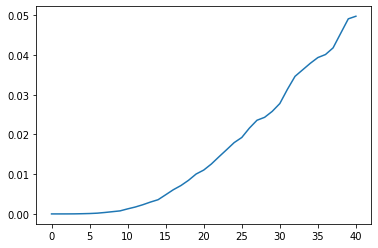

In [136]:
plt.plot(varss1)
#plt.plot(2*bpos/(mu**2))

In [106]:
for i,stb in enumerate(stops1):
    m=0
    mt=0
    enn=1
    for nn in stb:
        m+=(nn-m)/enn
        mt+=(nn**2 - mt)/enn
        enn+=1
    varss[i] = mt - m**2

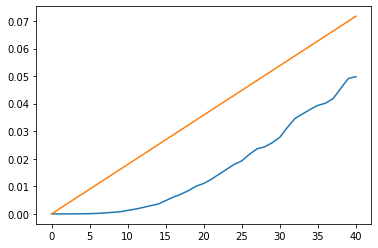

In [137]:
plt.plot(varss)
plt.plot(2*bpos/(mu**2))

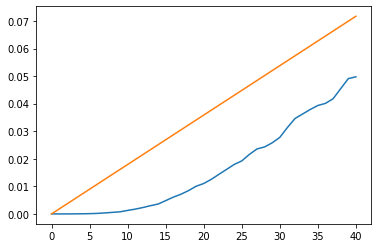

In [104]:
plt.plot(varss)
plt.plot(2*bpos/(mu**2))

In [71]:
means1 = [np.mean(k) for k in stops1]
std1 = [np.std(k) for k in stops1]

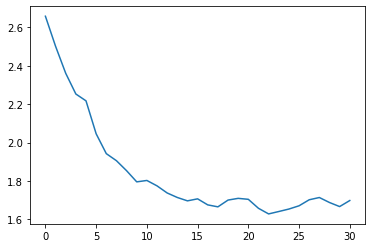

In [91]:
plt.plot(((bpos/mu)/std1)[10:])

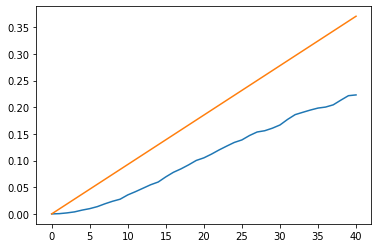

In [86]:
plt.plot(std1)
plt.plot(bpos/mu0)

In [82]:
bpos/mu

array([3.36348464e-16, 9.46736761e-03, 1.89347352e-02, 2.84021028e-02,
       3.78694705e-02, 4.73368381e-02, 5.68042057e-02, 6.62715733e-02,
       7.57389409e-02, 8.52063085e-02, 9.46736761e-02, 1.04141044e-01,
       1.13608411e-01, 1.23075779e-01, 1.32543147e-01, 1.42010514e-01,
       1.51477882e-01, 1.60945249e-01, 1.70412617e-01, 1.79879985e-01,
       1.89347352e-01, 1.98814720e-01, 2.08282088e-01, 2.17749455e-01,
       2.27216823e-01, 2.36684190e-01, 2.46151558e-01, 2.55618926e-01,
       2.65086293e-01, 2.74553661e-01, 2.84021028e-01, 2.93488396e-01,
       3.02955764e-01, 3.12423131e-01, 3.21890499e-01, 3.31357867e-01,
       3.40825234e-01, 3.50292602e-01, 3.59759969e-01, 3.69227337e-01,
       3.78694705e-01])

In [95]:
stops1

41

Text(0.5, 0, '$\\alpha \\;error$')

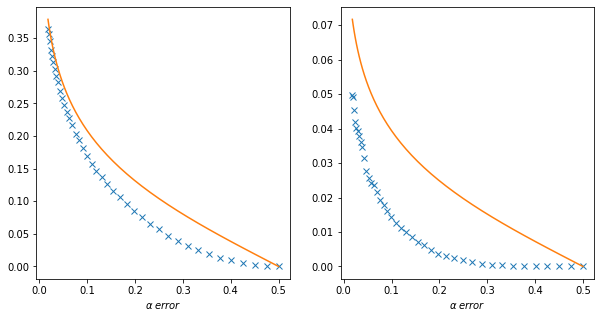

In [94]:
plt.figure(figsize=(10,5))
plt.title("mean value")
ax=plt.subplot(121)
ax.plot(avg_err_alpha(bpos),means1, 'x', label="numerics")
ax.plot(avg_err_alpha(bpos), bpos/mu, label="analytical")
ax.set_xlabel(r'$\alpha \;error$')

ax=plt.subplot(122)
ax.plot(avg_err_alpha(bpos),np.square(std1), 'x', label="numerics")
ax.plot(avg_err_alpha(bpos), 2*bpos/(mu**2), label="analytical")
ax.set_xlabel(r'$\alpha \;error$')

TypeError: unsupported operand type(s) for /: 'list' and 'int'

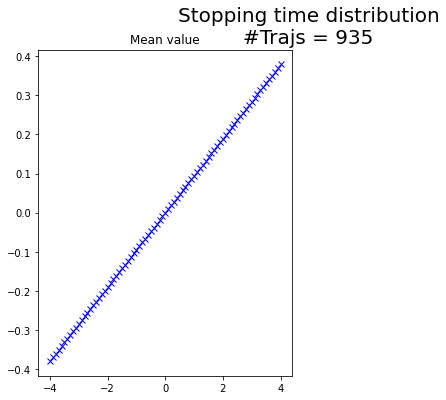

In [31]:
plt.figure(figsize=(10,6))
plt.suptitle("Stopping time distribution\n#Trajs = {}".format(len(stops)),size=20)
ax=plt.subplot(121)
ax.set_title("Mean value")
ax.plot(boundsB,boundsB/mu, 'x', color="blue", label="analytical")
ax.plot(bpos,np.mean(stops1,axis=0), 'o',color="red", label="numerics")
ax.set_xlabel("b", size=20)
ax=plt.subplot(122)
ax.set_title("Variance")
ax.plot(boundsB,boundsB/(mu**2), 'x', color="blue", label="analytical")
ax.plot(boundsB,np.std(stops1,axis=0)**2, 'o',color="red", label="numerics")
ax.set_xlabel("b", size=20)
#plt.savefig(path+"stopping_times_moments.pdf")

Deterministic strategies

In [67]:
alphas = list(deter["h0/h1"].values())
betas = list(deter["h1/h0"].values())

alphas = np.stack(alphas)
betas = np.stack(betas)



/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/nfs/pic.es/user/m/mbilkis/qenv_bilkis/lib64/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero e

Text(0, 0.5, 't')

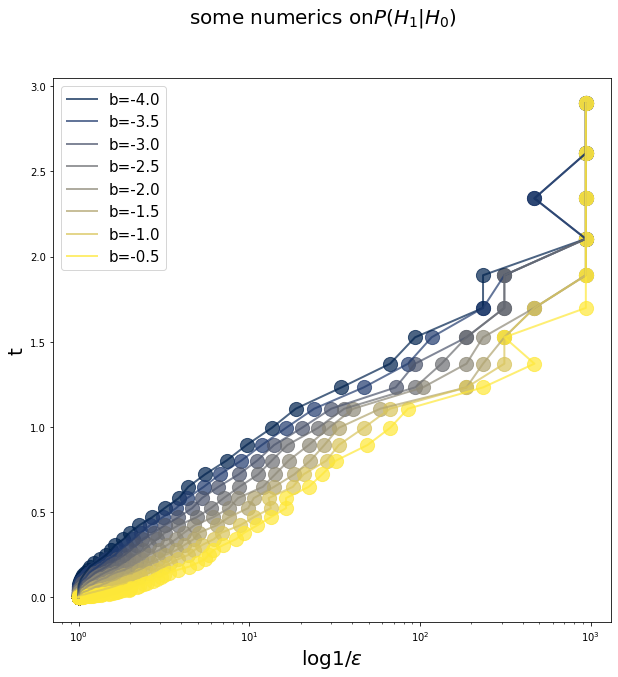

In [69]:
maps = plt.get_cmap("cividis")

plt.figure(figsize=(10,10))
plt.suptitle("some numerics on" + r'$P(H_1|H_0)$', size=20)
ax=plt.subplot(111)
indboundsplot = list(range(0,len(boundsB)))[0:38:5]
boundsplot = [boundsB[int(k)] for k in indboundsplot]
colors = maps(np.linspace(0,1,len(boundsplot)))
c=-1
for k, b in zip(indboundsplot, boundsplot):
    c+=1
    ax.scatter(1/betas[k,:],timind,  color=colors[c], s=200, alpha=0.7)
    ax.plot(1/betas[k,:],timind,  color=colors[c], linewidth=2, alpha=0.7, label="b={}".format(np.round(b,2)))
    
ax.legend(prop={"size":15})
ax.set_xscale("log")
ax.set_xlabel(r'$\log 1/\epsilon$',size=20)
ax.set_ylabel("t",size=20)